# Homework 4

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

## Task 0 Loading the data

We load the data, using an appropriate encoding - after error-and-trial:

In [2]:
train = pd.read_csv("data/reddit_200k_train.csv", encoding="ISO-8859-1", usecols=["body", "REMOVED"])
test = pd.read_csv("data/reddit_200k_test.csv", encoding="ISO-8859-1", usecols=["body", "REMOVED"])

We peek at our train data:

In [3]:
train.head()

,body,REMOVED
0,I've always been taught it emerged from the ea...,False
1,"As an ECE, my first feeling as ""HEY THAT'S NOT...",True
2,Monday: Drug companies stock dives on good new...,True
3,i learned that all hybrids are unfertile i won...,False
4,Well i was wanting to get wasted tonight. Not...,False


How many instances do we have?

In [6]:
train.shape

(167529, 2)

#### Evaluation metric:

Let us see the proportion of each class in the training data:

In [7]:
target_counts = np.bincount(train['REMOVED'])
print("There are {:d} of the `True` class.".format(target_counts[1]))
print("There are {:d} of the `False` class.".format(target_counts[0]))

There are 64738 of the `True` class.
There are 102791 of the `False` class.


We have a bit of an imbalance problem here, so we'll choose to evaluate our algorithms using the **ROC AUC**, which should give insight on the performance of our models without being too misleading with regard to the class imbalance.

## Task 1 Bag of Words and simple Features

### 1.1 Create a baseline model using a bag-of-words approach and a linear model.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

We instantiate the BoW model with default parameters (the token pattern excluding one letter words, no limitation on features extracted, no minimum requirements on the number of documents a word appears in, and no filter on stop words):

In [23]:
vect = CountVectorizer()

We fit the model to fetch the vocabulary and use it to transform our data to a BoW:

In [24]:
train_bag = vect.fit_transform(train['body'])

How many different type of tokens were created?

In [25]:
len(vect.vocabulary_)

113804

We look at a few samples of the vocabulary:

In [12]:
vect.get_feature_names()[::10000]

['00',
 '663',
 'babysitter',
 'compassing',
 'eggsâ',
 'greenaway',
 'kajillion',
 'mosanto',
 'phylogenetic',
 'russkies',
 'surrogacy',
 'warned']

We now fit a - AUC-driven, grid-searched - linear model (logistic regression with L2 penalty) on top of this BoW representation:

In [162]:
from sklearn.linear_model import LogisticRegressionCV

In [14]:
baseline = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [15]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    baseline.fit(train_bag, train['REMOVED'])

We retrieve the cross-validation auc for the best model:

In [16]:
auc_base = baseline.scores_[True].mean(axis=0).max()
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


We plot the **PR and ROC curves** on the **test set** and compute the AUC to gain more insight on the model performance (*we will do so for the baseline, the preferred model we build from a BoW representation in Task 1 and the preferred model using word vectors in Task 2*):

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [18]:
test_bag = vect.transform(test['body'])

In [19]:
baseline_auc = roc_auc_score(test['REMOVED'], 
                             baseline.predict_proba(test_bag)[:, 1])

In [21]:
print("The BASELINE MODEL auc is .{0:.3f}".format(baseline_auc))

The BASELINE MODEL auc is .0.768


In [22]:
precision, recall, _ = precision_recall_curve(test['REMOVED'], 
                                              baseline.predict_proba(test_bag)[:, 1])
fpr, tpr, _ = roc_curve(test['REMOVED'], 
                        baseline.predict_proba(test_bag)[:, 1])

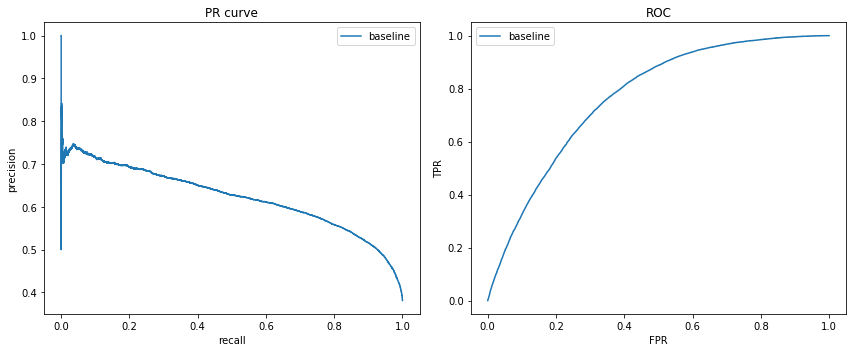

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, label="baseline")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc="best")

ax[1].plot(fpr, tpr, label="baseline")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc="best")

fig.tight_layout()

One shouldn't be too surprised at the PR curve, which looks chaotic for low recalls. A PR curve should be monotonous with respect to recall but not precision necessarily. Having some misclassified points with probabilities far from their true classes can lead to such a curve as above.

The overall performance of the baseline looks pretty suboptimal and we will explore ways to improve it in the following.

### 1.2 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoWmodel. Be aware that you might need to adjust the (regularization of the) linear model fordifferent feature sets.

**We will try different strategies to modify the BoW representation - and hopefully improve it -, always reporting the validation AUC to compare to the baseline.**

**We will also plot PR and ROC curves on the test set for the most promising model and compare those to the baseline.**

#### Using n-grams

We will try to fit a model with an n-gram representation with n ranging from 1 to 2 - choosing a minimum of documents in which a word appear to be 6 to limit the number of features - in an effort to avoid overfitting with an overbearing number of features compared to the number of training instances.

In [24]:
ngram_vect = CountVectorizer(ngram_range=(1, 2), min_df=6)

In [25]:
train_ngram_bag = ngram_vect.fit_transform(train['body'])

The vocabulary size is now:

In [26]:
len(ngram_vect.vocabulary_)

147372

Examples of tokens:

In [27]:
ngram_vect.get_feature_names()[::10000]

['00',
 'and pretend',
 'bertrand',
 'contacts',
 'empirical data',
 'get something',
 'in being',
 'lentils',
 'myopia',
 'org 2018',
 'rats do',
 'smoking cigs',
 'that wasn',
 'to bind',
 'went down']

Cross-validating (grid-searching the best regularization parameter) the logistic regression:

In [28]:
ngram_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [29]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ngram_model.fit(train_ngram_bag, train['REMOVED'])

Compare with baseline:

In [30]:
auc_ngram = ngram_model.scores_[True].mean(axis=0).max()
print('The logistic regression N-GRAM MODEL validation roc auc is {0:.3f}'.format(auc_ngram))

The logistic regression N-GRAM MODEL validation roc auc is 0.763


In [31]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


We have a slight improvement of AUC, but we also added close to 30,000 features. The improvement does not seem to justify the large increase in number of features. We might need to combine n-grams with other tuning parameters to obtain a sensible gain in AUC.

#### Using characters

We now fit a model with an n-gram character representation with n ranging from 2 to 4 - choosing a minimum of documents in which a word appear to be 6 to limit the number of features.

In [32]:
char_vect = CountVectorizer(ngram_range=(2, 4), min_df=6, analyzer='char')

In [33]:
train_char_bag = char_vect.fit_transform(train['body'])

The vocabulary size is now:

In [34]:
len(char_vect.vocabulary_)

126910

Examples of tokens:

In [35]:
char_vect.get_feature_names()[::10000]

['\t&',
 '"wai',
 '/) a',
 '4/) ',
 'a, t',
 'cow ',
 'ere&',
 'i "',
 'llow',
 'o ht',
 'rb ',
 't/47',
 'wths']

Cross-validating (grid-searching the best regularization parameter) the logistic regression:

In [36]:
char_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [37]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    char_model.fit(train_char_bag, train['REMOVED'])

Compare with baseline:

In [38]:
auc_char = char_model.scores_[True].mean(axis=0).max()
print('The logistic regression CHARACTER MODEL validation roc auc is {0:.3f}'.format(auc_char))

The logistic regression CHARACTER MODEL validation roc auc is 0.780


In [39]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


The AUC has significantly improved with an addition of 10,000 features (~10% of baseline features), using character n-grams seems promising. We will try to incorporate it and combine it with other tuning parameters to find a better model.

#### Using tf-idf rescaling

We know use tf-idf weighting on the word counts with a base word count vectorizer (and l2 normalization on each row).

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
tfidf_vect = TfidfVectorizer()

In [42]:
train_tfidf_bag = tfidf_vect.fit_transform(train['body'])

The vocabulary size is now:

In [43]:
len(tfidf_vect.vocabulary_)

113804

As expected, it is the same as the baseline vocabulary size - only the count values are now weighted using the tf-idf scheme.

Examples of tokens:

In [44]:
tfidf_vect.get_feature_names()[::10000]

['00',
 '663',
 'babysitter',
 'compassing',
 'eggsâ',
 'greenaway',
 'kajillion',
 'mosanto',
 'phylogenetic',
 'russkies',
 'surrogacy',
 'warned']

Cross-validating (grid-searching the best regularization parameter) the logistic regression:

In [45]:
tfidf_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [46]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tfidf_model.fit(train_tfidf_bag, train['REMOVED'])

Compare with baseline:

In [47]:
auc_tfidf = tfidf_model.scores_[True].mean(axis=0).max()
print('The logistic regression TFIDF MODEL validation roc auc is {0:.3f}'.format(auc_tfidf))

The logistic regression TFIDF MODEL validation roc auc is 0.768


In [48]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


The results are better than the baseline, less significantly so than just using character n-grams without tf-idf. One could hope that combining both will significantly improve our metrics.

#### Throwing away stop words

In [57]:
stop_vect = CountVectorizer(stop_words="english")

In [58]:
train_stop_bag = stop_vect.fit_transform(train['body'])

In [59]:
len(stop_vect.vocabulary_)

113494

In [60]:
stop_vect.get_feature_names()[::10000]

['00',
 '663',
 'backdoors',
 'complacency',
 'ehp2773',
 'griffiths',
 'karelin',
 'mounties',
 'piercings',
 's00426',
 'sweatiest',
 'weakening']

Cross-validating (grid-searching the best regularization parameter) the logistic regression:

In [61]:
stop_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [62]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stop_model.fit(train_stop_bag, train['REMOVED'])

Compare with baseline:

In [63]:
auc_stop = stop_model.scores_[True].mean(axis=0).max()
print('The logistic regression STOP-WORDS MODEL validation roc auc is {0:.3f}'.format(auc_stop))

The logistic regression STOP-WORDS MODEL validation roc auc is 0.752


In [64]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


Removing stop words actually worsens the performance of the baseline! It seems that stop words might be informative in our context of moderating the thread.

#### Combining different tuning parameters

We now combine several tuning parameters to hopefully get better validation results. Splitting the data into character n-grams seemed promising, so *we decided to combine this representation with a tf-idf weighting, removing character n-grams that are too rare*.

In [50]:
comb_vect = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=6)

In [51]:
train_comb_bag = comb_vect.fit_transform(train['body'])

In [53]:
len(comb_vect.vocabulary_)

126910

In [54]:
comb_vect.get_feature_names()[::10000]

['\t&',
 '"wai',
 '/) a',
 '4/) ',
 'a, t',
 'cow ',
 'ere&',
 'i "',
 'llow',
 'o ht',
 'rb ',
 't/47',
 'wths']

In [55]:
comb_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [56]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    comb_model.fit(train_comb_bag, train['REMOVED'])

In [57]:
auc_comb = comb_model.scores_[True].mean(axis=0).max()
print('The logistic regression COMBINED MODEL validation roc auc is {0:.3f}'.format(auc_comb))

The logistic regression COMBINED MODEL validation roc auc is 0.789


In [58]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


This is the best ROC AUC we have seen as of yet. **We will stop the model selection process based on the BoW representation only now and report results on the test set of this improved character-tfidf-BoW model**:

In [80]:
comb_bag = comb_vect.transform(test['body'])

In [82]:
comb_model_auc = roc_auc_score(test['REMOVED'], 
                               comb_model.predict_proba(comb_bag)[:, 1])

In [84]:
print("The AUC on the test set is {0:.3f}".format(comb_model_auc))

The AUC on the test set is 0.798


In [86]:
print("The AUC of the baseline on the test set is {0:.3f}".format(baseline_auc))

The AUC of the baseline on the test set is 0.768


In [91]:
precision2, recall2, _ = precision_recall_curve(test['REMOVED'], 
                                              comb_model.predict_proba(comb_bag)[:, 1])
fpr2, tpr2, _ = roc_curve(test['REMOVED'], 
                        comb_model.predict_proba(comb_bag)[:, 1])

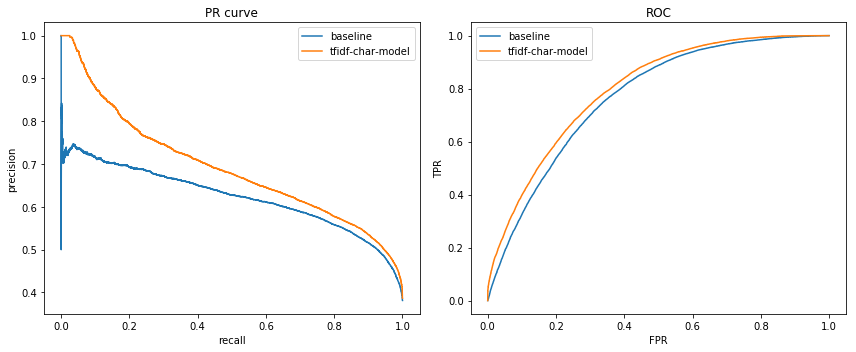

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, label="baseline")
ax[0].plot(recall2, precision2, label="tfidf-char-model")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc="best")

ax[1].plot(fpr, tpr, label="baseline")
ax[1].plot(fpr2, tpr2, label="tfidf-char-model")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc="best")

fig.tight_layout()

The new model performs better on the test data as both its curves are systematically above the baseline's.

### 1.3 Explore other features you can derive from the text, such as html, length, punctuation,capitalization or other features you deem important from exploring the dataset

Ideas: 

from https://www.kaggle.com/alber8295/kisa-md-trabajo-final-an-lisis-de-datos
clean words for the ngram part (keep only letters and spaces)

from https://www.kaggle.com/areeves87/xgb-lgbm-glmnet-on-text2vec-tf-idf-auc-0-821
stemming before making BoW

from https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams/code
limit the number of features

from https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
length of the comment in words,
length of the comment in characters

from https://www.kaggle.com/areeves87/nbsvm-w-char-grams-auc-824
combine both word and character mappings (with hstack)

## Task 2 Word Vectors

### Use a pretrained word-embedding (word2vec, glove or fasttext) instead of the bag-of-words model. Does this improve classification?

(pour nous) From kernel https://www.kaggle.com/mitchelldehaven/cnn-with-fasttext-auc-0-800: use fasttext rather than word2vec (significantly more words in the testing and training corpora have embeddings in fasttext than in word2vec).

In [156]:
from gensim import models


In [41]:
import re

In [33]:
m = models.KeyedVectors.load_word2vec_format("word_vectors/wiki-news-300d-1M-subword.vec")


In [100]:
train_vec = [np.mean([m[w] for w in list(filter(None, re.split("[' .]", doc))) 
                      if w in m.vocab], axis=0) 
             for doc in train['body']]


In [157]:
indices = []
for i in range(len(train_vec)):
    if (isinstance(train_vec[i], np.ndarray)):
        indices.append(i)

In [158]:
train_vec = [train_vec[doc] for doc in indices]

In [159]:
target_vec = train.iloc[indices, 1]

In [160]:
train_vec = np.vstack(train_vec)

In [163]:
lr_w2v = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)


In [164]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_w2v.fit(train_vec, target_vec)
    

In [165]:
auc_vec = lr_w2v.scores_[True].mean(axis=0).max()
print('The logistic regression COMBINED MODEL validation roc auc is {0:.3f}'.format(auc_vec))

The logistic regression COMBINED MODEL validation roc auc is 0.718
